In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

import itertools
import os
import shutil
import random
import glob
import warnings
from random import randint
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
print("Num GPU:", len(physical_device))
tf.config.experimental.set_memory_growth(physical_device[0], True)

Num GPU: 1


# Prepare Image
Dataset/

    train/
        0/
        ...
        9/
    valid/
        0/
        ...
        9/
     test/
        0/
        ...
        9/

In [ ]:
#Реорганизация расположения данных
os.chdir('Dataset')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


# Train, valid, test data

In [9]:
path = 'F:\Git_Clone\Gesture_Recognition\Dataset/'
train_path = path + 'train'
valid_path = path + 'valid'
test_path = path + 'test'

In [10]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory = train_path, target_size = (224,224),  batch_size = 32)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory = valid_path, target_size = (224,224), batch_size = 32)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory = test_path, target_size = (224,224), batch_size = 32, shuffle = False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


# Prepare Models 
https://deeplizard.com/learn/video/Zrt76AIbeh4

In [11]:
mobile_model = tf.keras.applications.mobilenet.MobileNet()

In [12]:
#x = mobile.layers[-5].output
#x = tf.keras.layers.Flatten()(x) 
#output = Dense(units=10, activation='softmax')(x)
mobile_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [16]:
x = mobile_model.layers[-5].output
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
output = Dense(units=10, activation='softmax')(x)
model = Model(inputs=mobile_model.input, outputs=output)

In [17]:
#freze Learning layers
for layer in model.layers[:-22]:
    layer.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

# Train models

In [27]:
model.compile(optimizer = Adam(learning_rate =0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [33]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('sparse_categorical_crossentropy')
  ax1.legend()
  
  ax1.grid(True)


  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  ax2.grid(True)



  plt.show()



def get_pred_report(model, x, test_y):
  predictions = model.predict(x = x, batch_size= 32, verbose = 0)
  predictions = np.argmax(predictions, axis =-1)
  print(classification_report(predictions, test_y))
  return predictions

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
def fit_models(model, train_batches, valid_batches, epochs = 10, verbose = 2):
    history = model.fit(
        x = train_batches,
        steps_per_epoch=len(train_batches),
        validation_data = valid_batches,
        validation_steps=len(valid_batches),
        epochs = epochs,
        verbose = verbose
    )
    
    return model, history

In [28]:
train_model, history = fit_models(model, train_batches, valid_batches, epochs = 10)

Epoch 1/10
54/54 - 5s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0923 - val_accuracy: 0.9900 - 5s/epoch - 88ms/step
Epoch 2/10
54/54 - 2s - loss: 9.0203e-04 - accuracy: 1.0000 - val_loss: 0.0988 - val_accuracy: 0.9800 - 2s/epoch - 45ms/step
Epoch 3/10
54/54 - 2s - loss: 4.6859e-04 - accuracy: 1.0000 - val_loss: 0.0931 - val_accuracy: 0.9833 - 2s/epoch - 45ms/step
Epoch 4/10
54/54 - 2s - loss: 3.2888e-04 - accuracy: 1.0000 - val_loss: 0.0930 - val_accuracy: 0.9800 - 2s/epoch - 46ms/step
Epoch 5/10
54/54 - 2s - loss: 2.2216e-04 - accuracy: 1.0000 - val_loss: 0.0810 - val_accuracy: 0.9900 - 2s/epoch - 46ms/step
Epoch 6/10
54/54 - 2s - loss: 1.4252e-04 - accuracy: 1.0000 - val_loss: 0.0795 - val_accuracy: 0.9900 - 2s/epoch - 45ms/step
Epoch 7/10
54/54 - 3s - loss: 1.5158e-04 - accuracy: 1.0000 - val_loss: 0.0743 - val_accuracy: 0.9933 - 3s/epoch - 47ms/step
Epoch 8/10
54/54 - 2s - loss: 1.2523e-04 - accuracy: 1.0000 - val_loss: 0.0783 - val_accuracy: 0.9933 - 2s/epoch - 46ms/step
Epoc

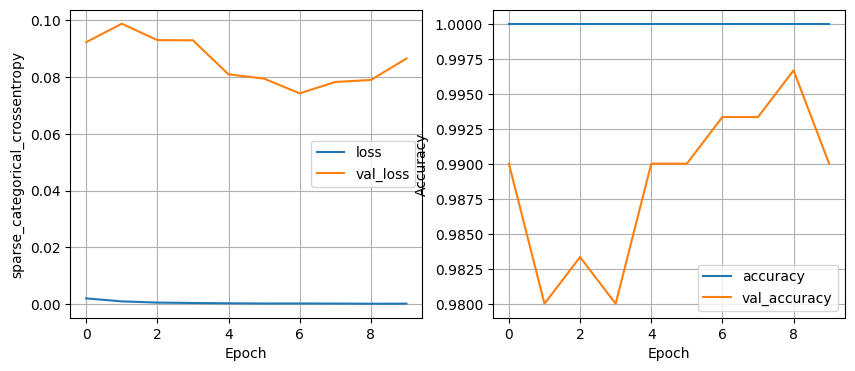

In [29]:
plot_history(history)

In [30]:
test_imgs, test_labels = next(test_batches)

predict = train_model.predict(x = test_batches)
np.round(predict)
test_batches.classes.shape

2/2 [==============================] - 1s 503ms/step


(50,)

In [32]:
predictions = get_pred_report(train_model,test_batches,test_batches.classes)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.80      1.00      0.89         4
           3       0.80      0.80      0.80         5
           4       1.00      1.00      1.00         5
           5       1.00      0.83      0.91         6
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



In [34]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 1 0 0 0 0 0 0]
 [0 0 0 4 0 1 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


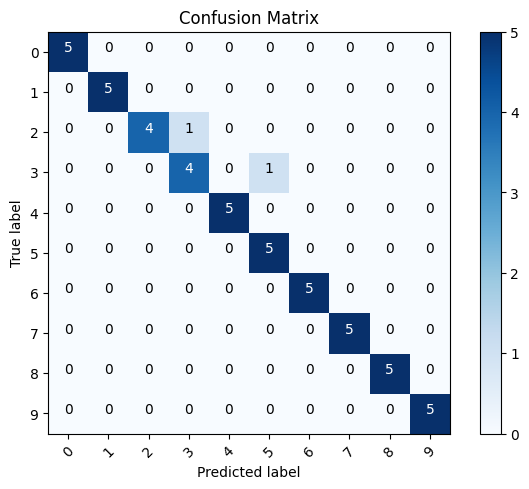

In [38]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = predictions)
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')